# Transfer Leraning with ResNet for EuroSat Image Dataset - Version 2
- The data is alread split into train, validation and test sets
  - Train - 70%
  - Validation - 20 %
  - Test - 10 %
- In this version, I append a new network head.
  - Two hidden layers with ReLU and Dropout
  - FC output layer
-Also, I set its parameters to non-trainable

#1. Setup the environment

In [1]:
#Import the necessary packages
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet50
from torchvision import transforms
from tqdm import tqdm
from torch import nn
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import shutil
import torch
import time
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#/content/drive/MyDrive/ML_Project2022/dataset/train

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec  3 15:57:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    50W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [6]:
#Specify ImageNet mean and standard deviation and image size
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224

# determine the device to be used for training and evaluation
DEVICE = get_default_device()

#Now the data is already split following are the paths from Google drive
TRAIN_DS_PATH = '/content/drive/MyDrive/ML_Project2022/dataset/train'
VAL_DS_PATH = '/content/drive/MyDrive/ML_Project2022/dataset/val'
TEST_DS_PATH = '/content/drive/MyDrive/ML_Project2022/dataset/test'

# specify training hyperparameters
BATCH_SIZE = 64
PRED_BATCH_SIZE = 4
EPOCHS = 20
LR = 0.001
#LR_FINETUNE = 0.0005

LOSS_PLOT_PATH = '/content/drive/MyDrive/ML_Project2022/plots/ResNet_Ver2_Loss.png'
ACC_PLOT_PATH = '/content/drive/MyDrive/ML_Project2022/plots/ResNet_Ver2_Acc.png'
MODEL_PATH = '/content/drive/MyDrive/ML_Project2022/models/ResNet_Ver2.pth'
HISTORY_PATH = '/content/drive/MyDrive/ML_Project2022/history/ResNet_Ver2.pt'

In [7]:
DEVICE

device(type='cuda')

#2. Train and test augmentation pipelines

In [8]:
#Define augmentation pipelines
trainTansform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])
valTransform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

#3. Dataloaders

In [9]:
def get_dataloader(rootDir, transforms, batchSize, shuffle=True):
    # create a dataset and use it to create a data loader
    ds = datasets.ImageFolder(root=rootDir,
            transform=transforms)
    loader = DataLoader(ds, batch_size=batchSize,
            shuffle=shuffle,
            num_workers=os.cpu_count(),
            pin_memory=True if DEVICE.type == 'cuda' else False)

    # return a tuple of  the dataset and the data loader
    return (ds, loader)

In [10]:
# create data loaders
(trainDS, trainLoader) = get_dataloader(TRAIN_DS_PATH, 
                                        transforms=trainTansform, 
                                        batchSize=BATCH_SIZE,
                                        shuffle=True)
(valDS, valLoader) = get_dataloader(VAL_DS_PATH,
                                    transforms=valTransform, 
                                    batchSize=
                                    BATCH_SIZE, 
                                    shuffle=False)

#4. ResNet50 Model
- 

## 4.1 Initializations

In [11]:
from torchvision.models import ResNet50_Weights
# load up the ResNet50 model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
numFeatures = model.fc.in_features

# since we are using the ResNet50 model as a feature extractor set
# its parameters to non-trainable
# this is essentially freezing all the weights
for param in model.parameters():
	param.requires_grad = False

# define the network head and attach it to the model
model_head = nn.Sequential(
    nn.Linear(numFeatures, 512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(trainDS.classes))

)
model.fc = model_head

# set device
model = model.to(DEVICE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(valDS) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
H_batch = {"batch_train_loss": []}

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## 4.2 Training

In [12]:
# initialize loss function and optimizer (notice that we are only
# providing the parameters of the classification top to our optimizer)
lossFunc = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=LR)

In [13]:
# loop over epochs
print("Training the network...")
startTime = time.time()
for e in tqdm(range(EPOCHS)):
    # set the model in training mode
    model.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0

    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0

    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))

        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunc(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item() 
        H_batch["batch_train_loss"].append(loss.cpu().detach().numpy())   
    
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()

        # loop over the validation set
        for (x, y) in valLoader:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))

            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFunc(pred, y)

            # calculate the number of correct predictions
            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDS)
    valCorrect = valCorrect / len(valDS)

    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)

    # print the model training and validation information
    print("EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(avgValLoss, valCorrect))

# display the total time needed to perform the training
endTime = time.time()
training_time = endTime - startTime
print("Total time taken to train the model: {:.2f}s".format(training_time))


Training the network...


  5%|▌         | 1/20 [08:16<2:37:22, 496.97s/it]

EPOCH: 1/20
Train loss: 0.665880, Train accuracy: 0.7777
Val loss: 0.385407, Val accuracy: 0.8678


 10%|█         | 2/20 [08:34<1:04:33, 215.20s/it]

EPOCH: 2/20
Train loss: 0.365741, Train accuracy: 0.8756
Val loss: 0.280026, Val accuracy: 0.9059


 15%|█▌        | 3/20 [08:52<35:27, 125.14s/it]  

EPOCH: 3/20
Train loss: 0.322045, Train accuracy: 0.8923
Val loss: 0.257238, Val accuracy: 0.9120


 20%|██        | 4/20 [09:10<22:05, 82.87s/it] 

EPOCH: 4/20
Train loss: 0.303942, Train accuracy: 0.9019
Val loss: 0.251731, Val accuracy: 0.9115


 25%|██▌       | 5/20 [09:28<14:52, 59.49s/it]

EPOCH: 5/20
Train loss: 0.293377, Train accuracy: 0.9040
Val loss: 0.223583, Val accuracy: 0.9237


 30%|███       | 6/20 [09:47<10:35, 45.40s/it]

EPOCH: 6/20
Train loss: 0.274646, Train accuracy: 0.9079
Val loss: 0.224384, Val accuracy: 0.9276


 35%|███▌      | 7/20 [10:05<07:55, 36.59s/it]

EPOCH: 7/20
Train loss: 0.264729, Train accuracy: 0.9107
Val loss: 0.241670, Val accuracy: 0.9185


 40%|████      | 8/20 [10:24<06:11, 30.98s/it]

EPOCH: 8/20
Train loss: 0.254664, Train accuracy: 0.9154
Val loss: 0.208956, Val accuracy: 0.9300


 45%|████▌     | 9/20 [10:43<04:58, 27.10s/it]

EPOCH: 9/20
Train loss: 0.245780, Train accuracy: 0.9166
Val loss: 0.228166, Val accuracy: 0.9213


 50%|█████     | 10/20 [11:01<04:04, 24.49s/it]

EPOCH: 10/20
Train loss: 0.243603, Train accuracy: 0.9185
Val loss: 0.206398, Val accuracy: 0.9304


 55%|█████▌    | 11/20 [11:20<03:24, 22.69s/it]

EPOCH: 11/20
Train loss: 0.243746, Train accuracy: 0.9178
Val loss: 0.208820, Val accuracy: 0.9307


 60%|██████    | 12/20 [11:38<02:51, 21.46s/it]

EPOCH: 12/20
Train loss: 0.236853, Train accuracy: 0.9207
Val loss: 0.220193, Val accuracy: 0.9224


 65%|██████▌   | 13/20 [11:57<02:24, 20.65s/it]

EPOCH: 13/20
Train loss: 0.224636, Train accuracy: 0.9243
Val loss: 0.206392, Val accuracy: 0.9300


 70%|███████   | 14/20 [12:16<02:01, 20.18s/it]

EPOCH: 14/20
Train loss: 0.225958, Train accuracy: 0.9233
Val loss: 0.194436, Val accuracy: 0.9335


 75%|███████▌  | 15/20 [12:35<01:38, 19.73s/it]

EPOCH: 15/20
Train loss: 0.220448, Train accuracy: 0.9257
Val loss: 0.196174, Val accuracy: 0.9354


 80%|████████  | 16/20 [12:54<01:17, 19.42s/it]

EPOCH: 16/20
Train loss: 0.220750, Train accuracy: 0.9281
Val loss: 0.187814, Val accuracy: 0.9354


 85%|████████▌ | 17/20 [13:12<00:57, 19.21s/it]

EPOCH: 17/20
Train loss: 0.212772, Train accuracy: 0.9291
Val loss: 0.178950, Val accuracy: 0.9402


 90%|█████████ | 18/20 [13:31<00:38, 19.05s/it]

EPOCH: 18/20
Train loss: 0.219834, Train accuracy: 0.9253
Val loss: 0.181254, Val accuracy: 0.9387


 95%|█████████▌| 19/20 [13:50<00:18, 18.95s/it]

EPOCH: 19/20
Train loss: 0.214284, Train accuracy: 0.9284
Val loss: 0.222062, Val accuracy: 0.9243


100%|██████████| 20/20 [14:08<00:00, 42.45s/it]

EPOCH: 20/20
Train loss: 0.208432, Train accuracy: 0.9317
Val loss: 0.217362, Val accuracy: 0.9256
Total time taken to train the model: 848.97s


In [14]:
# serialize the model to disk
torch.save(model, MODEL_PATH)

In [15]:
# serialize the history to disk
saveObject = {
    'train_losses': H_batch["batch_train_loss"],
    'avg_train_losses_per_epoch': H["train_loss"],
    'avg_val_losses_per_epoch': H["val_loss"],
    'avg_train_accs_per_epoch': H["train_acc"],
    'avg_val_accs_per_epoch': H["val_acc"],
    'training_time': training_time
}

torch.save(saveObject, HISTORY_PATH)

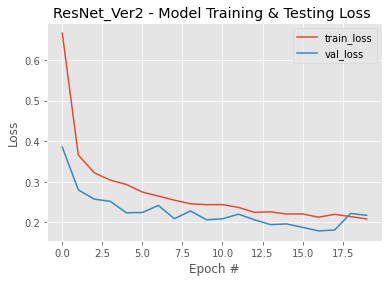

In [16]:
# plot the training and testing loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("ResNet_Ver2 - Model Training & Testing Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig(LOSS_PLOT_PATH)

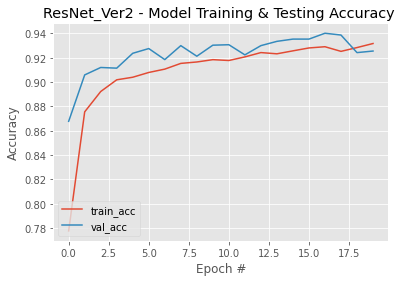

In [17]:
# plot the training and testing ccuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("ResNet_Ver2 - Model Training & Testing Accuracy ")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(ACC_PLOT_PATH)

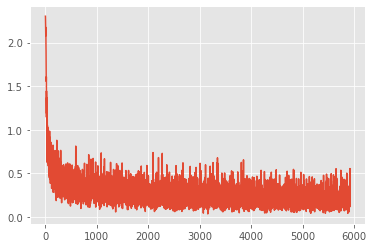

In [18]:
loadObject1 = torch.load(HISTORY_PATH)

plt.plot(loadObject1['train_losses'])

In [19]:
print(loadObject1['avg_train_losses_per_epoch'])
print(loadObject1['avg_val_losses_per_epoch'])
print(loadObject1['avg_train_accs_per_epoch'])
print(loadObject1['avg_val_accs_per_epoch'])
print(loadObject1['training_time'])

[array(0.6658798, dtype=float32), array(0.3657414, dtype=float32), array(0.32204524, dtype=float32), array(0.30394185, dtype=float32), array(0.29337695, dtype=float32), array(0.27464613, dtype=float32), array(0.2647294, dtype=float32), array(0.254664, dtype=float32), array(0.24577978, dtype=float32), array(0.24360266, dtype=float32), array(0.24374588, dtype=float32), array(0.23685336, dtype=float32), array(0.22463596, dtype=float32), array(0.22595763, dtype=float32), array(0.22044763, dtype=float32), array(0.22075039, dtype=float32), array(0.2127719, dtype=float32), array(0.21983433, dtype=float32), array(0.21428359, dtype=float32), array(0.20843151, dtype=float32)]
[array(0.3854071, dtype=float32), array(0.2800255, dtype=float32), array(0.25723818, dtype=float32), array(0.2517306, dtype=float32), array(0.22358268, dtype=float32), array(0.22438395, dtype=float32), array(0.2416699, dtype=float32), array(0.20895597, dtype=float32), array(0.22816586, dtype=float32), array(0.20639843, dtyp

#5. Test Set Accuracy

In [20]:
(testDS, testLoader) = get_dataloader(TEST_DS_PATH,
                                    transforms=valTransform, 
                                    batchSize=
                                    PRED_BATCH_SIZE, 
                                    shuffle=False)

testSteps = len(testDS) // PRED_BATCH_SIZE
testCorrect = 0

with torch.no_grad():
      # set the model in evaluation mode
      model.eval()

      totalTestlCorrect = 0

      # loop over the test set
      for (x, y) in testLoader:
          # send the input to the device
          (x, y) = (x.to(DEVICE), y.to(DEVICE))

          # make the predictions
          pred = model(x)

          # calculate the number of correct predictions
          testCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

# calculate the test accuracy
testCorrect = testCorrect / len(testDS)

print('Test accuracy: ', testCorrect)

Test accuracy:  0.92
